In [1]:
import os
import sys
import pickle
import warnings 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy import stats

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

#### TODO:
0) Lav noget cleanup af funktioner (indbyg mean i extract og væk med std for cluster size etc)
01) Måske er et hist af Nfraction og clustersize med sammenligning og kolmogrov et renere resultat
1) Gør stat.-analysen præsenterbar
2) Indsæt .225 when done
3) Overvej Nmin. Er 3 OK?
4) Prøv at smide noise ind på N i Poisson og se forskel(eller initaliser præcist ud fra N i hvert frame)
5) Efter proof of concept, byg det ind i infrastrukturen og lav analysen på tværs af L

In [118]:
X.shape

(5, 4, 5)

In [211]:
X = np.linspace(1, 100, 100).reshape(5, 4, 5)
NN = 9
a = np.random.choice(X[:,0,2], size=1)
int(a)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13540\4271855287.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(a)


23

In [212]:
def gen_clustering_metadata(path,):

    Nexp_list = []
    act_list = []
    act_dir_list = []
 
    for i, dir in enumerate(os.listdir(path)):
        if dir.startswith('analysis'):
            act_list.append(float(dir.split('_')[-1]))
            act_dir_list.append(os.path.join(path, dir))
    for i, file in enumerate(os.listdir(os.path.join(path, os.listdir(path)[0]))):
        if file.startswith('zeta'):
            Nexp_list.append(int(file.split('_')[-1]))

    return Nexp_list, act_list, act_dir_list


def do_poisson_clustering(Nlist, L, Ntrial, Ncmin = 2, method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=33)):
    """
    Perform the poisson clustering for a given set of parameters
    """

    cluster_arr = np.nan * np.zeros([4, len(Nlist), Ntrial])

    for i, N in enumerate(Nlist):

        p_arr = np.random.rand(N, 2, Ntrial) * L   
        cst = AgglomerativeClustering(**method_kwargs)

        for j in range(Ntrial):

            # Get defect array for frame
            defect_positions = p_arr[:, :, j]

            labels = cst.fit_predict(defect_positions)

            unique, counts = np.unique(labels, return_counts=True)

            # Only count clusters with more than Ncmin defects
            mask = (counts >= Ncmin)
            counts_above_min = counts[mask]

            # store the total number of defects
            cluster_arr[0, i, j] = N

            # store the number of clustered defects
            cluster_arr[1, i, j] = counts_above_min.sum()

            # store the number of clusters
            cluster_arr[2, i, j] = len(counts_above_min)
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                # store the average cluster size
                cluster_arr[3, i, j] = np.mean(counts_above_min)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cl_mean = np.nanmean(cluster_arr, axis = -1)
        cl_std = np.nanstd(cluster_arr, axis = -1)
        cl_std /= np.sqrt(Ntrial)

    return cluster_arr, cl_mean, cl_std



def do_poisson_clustering2(def_arr, L, Ntrial, Ncmin = 2, method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=33)):
    """
    def_arr must have format (Ndefect_entries, Nactivities)

    Perform the poisson clustering for a given set of parameters
    """
    
    Ndef_entries, Nact = def_arr.shape
    Ntrial = min(Ntrial, Ndef_entries)

    cluster_arr = np.nan * np.zeros([4, Nact, Ntrial])

    for i in range(Nact):

        Ndefects_arr = np.random.choice(def_arr[:, i], size = Ntrial)

        for j in range(Ntrial):

            if np.isnan(Ndefects_arr[j]):
                continue

            # generate points
            N = int(Ndefects_arr[j])
            defect_positions = np.random.rand(N, 2) * L   

            # cluster
            cst = AgglomerativeClustering(**method_kwargs)
            labels = cst.fit_predict(defect_positions)

            unique, counts = np.unique(labels, return_counts=True)

            # Only count clusters with more than Ncmin defects
            mask = (counts >= Ncmin)
            counts_above_min = counts[mask]

            # store the total number of defects
            cluster_arr[0, i, j] = N

            # store the number of clustered defects
            cluster_arr[1, i, j] = counts_above_min.sum()

            # store the number of clusters
            cluster_arr[2, i, j] = len(counts_above_min)
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                # store the average cluster size
                cluster_arr[3, i, j] = np.mean(counts_above_min)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cl_mean = np.nanmean(cluster_arr, axis = -1)
        cl_std = np.nanstd(cluster_arr, axis = -1)
        cl_std /= np.sqrt(Ntrial)

    return cluster_arr, cl_mean, cl_std




def do_poisson_clustering3(def_arr, L, Ntrial, Ncmin = 2, method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=33)):
    """
    def_arr must have format (Ndefect_entries, Nactivities)

    Perform the poisson clustering for a given set of parameters
    """
    
    _, Nact = def_arr.shape

    cluster_arr = np.nan * np.zeros([4, Nact, Ntrial])

    for i in range(Nact):

        for j in range(Ntrial):

            N = np.random.choice(def_arr[:, i], size = 1)[0]

            if np.isnan(N):
                continue

            # generate points
            N = int(N)
            defect_positions = np.random.rand(N, 2) * L   

            # cluster
            cst = AgglomerativeClustering(**method_kwargs)
            labels = cst.fit_predict(defect_positions)

            unique, counts = np.unique(labels, return_counts=True)

            # Only count clusters with more than Ncmin defects
            mask = (counts >= Ncmin)
            counts_above_min = counts[mask]

            # store the total number of defects
            cluster_arr[0, i, j] = N

            # store the number of clustered defects
            cluster_arr[1, i, j] = counts_above_min.sum()

            # store the number of clusters
            cluster_arr[2, i, j] = len(counts_above_min)
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                # store the average cluster size
                cluster_arr[3, i, j] = np.mean(counts_above_min)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cl_mean = np.nanmean(cluster_arr, axis = -1)
        cl_std = np.nanstd(cluster_arr, axis = -1)
        cl_std /= np.sqrt(Ntrial)

    return cluster_arr, cl_mean, cl_std





def extract_clustering_results(Nframes, act_list, act_dir_list, Nexp, Ncmin=2, save = True,):
    """
    Analyse the defects for all the input folders
    """
    for N in range(1):

        # create arrays to store the clustering data
        cluster_arr = np.nan * np.zeros([Nframes, 5, len(act_list), Nexp])
        
        # print('Analysing clustering data for input folder {}'.format(self.input_paths[N]))
        for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):

            exp_list = []
            exp_dir_list = []

            for file in os.listdir(act_dir):
                exp_count = file.split('_')[-1]
                exp_list.append(int(exp_count))
                exp_dir_list.append(os.path.join(act_dir, file))

            # sort the activity list and the activity directory list
            exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

            for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):

                with open(os.path.join(exp_dir, 'labels_rm33.pkl'), 'rb') as f:
                        labels = pickle.load(f)
                nan_counter = 0
                for k, frame in enumerate(labels[:Nframes]):
                        
                        if frame is None:
                            nan_counter += 1
                            continue
                             
                        # store the number of defects 
                        cluster_arr[k, 0, i, j] = len(frame)

                        unique, counts = np.unique(frame, return_counts=True)

                        # Only count clusters with more than Ncmin defects
                        mask = (counts >= Ncmin)
                        counts_above_min = counts[mask]

                        # Find the sizes of the clusters and the number of clusters of each size
                        cluster_sizes, cluster_counts = np.unique(counts_above_min, return_counts=True)

                        # store the number of clustered defects
                        cluster_arr[k, 1, i, j] = counts_above_min.sum()
                        # store the number of clusters
                        cluster_arr[k, 2, i, j] = len(counts_above_min)
                
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=RuntimeWarning)
                            # store the average cluster size
                            cluster_arr[k, 3, i, j] = np.nanmean(counts_above_min)
                            # store the standard deviation of the cluster sizes
                            cluster_arr[k, 4, i, j] = np.nanstd(counts_above_min)
        if save:
            pass
    return cluster_arr

In [3]:
base_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na512'
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = 512, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = 512, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]

In [4]:
Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nframes_l = 400
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])
Nframes_vl = 1500

In [253]:
Ncmin = 4

cl_arr_l = extract_clustering_results(Nframes_l, act_l, act_dir_l, len(Nexp_l), Ncmin=Ncmin, save=False)
cl_arr_vl = extract_clustering_results(Nframes_vl, act_vl, act_dir_vl, len(Nexp_vl), Ncmin=Ncmin, save=False)

frame_idx_cutoff = Nframes_l
cl_arr_vl = cl_arr_vl[-frame_idx_cutoff:]
Nframes_vl = frame_idx_cutoff

cl_mean_l = np.nanmean(cl_arr_l, axis=(0,-1))
cl_std_l = np.nanstd(cl_arr_l, axis=(0,-1))
cl_std_l = cl_std_l  / np.sqrt(Nframes_l * len(Nexp_l))

# replace av cluster size std in cl_mean with std of mean from cl_std
cl_mean_l[-1, :] = cl_std_l[-2,:] 

cl_mean_vl = np.nanmean(cl_arr_vl, axis=(0,-1))
cl_std_vl = np.nanstd(cl_arr_vl, axis=(0,-1))
cl_std_vl = cl_std_vl  / np.sqrt(Nframes_vl * len(Nexp_vl))

# replace av cluster size std in cl_mean with std of mean from cl_std
cl_mean_vl[-1, :] = cl_std_vl[-2,:] 

cl_mean = np.concatenate([cl_mean_l[:,0][:, None], cl_mean_vl, cl_mean_l[:,1:]], axis=1)
cl_std = np.concatenate([cl_std_l[:,0][:, None], cl_std_vl, cl_std_l[:,1:]], axis=1)

act_list = np.unique(np.concatenate([act_l, act_vl, act_l[1:]]))

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13540\1430902531.py:10: RuntimeWarning: Mean of empty slice
  cl_mean_l = np.nanmean(cl_arr_l, axis=(0,-1))
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13540\1430902531.py:17: RuntimeWarning: Mean of empty slice
  cl_mean_vl = np.nanmean(cl_arr_vl, axis=(0,-1))


In [81]:
N_list = cl_mean[0,:].astype('int')  #+ (cl_std[0,:]  * np.sqrt(Nframes_l * len(Nexp_l))).astype('int')
Rmax = 33
method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax)

L = 512
Rmax = 33
Ntrial = 1500

cl_arr_uni , cl_mean_uni, cl_std_uni = do_poisson_clustering(N_list, L, Ntrial, Ncmin = Ncmin, method_kwargs = method_kwargs)

In [200]:
L = 512
Rmax = 33
Ntrial = Nframes_l * len(Nexp_l)
method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax)

def_arr = np.concatenate([cl_arr_l[:, 0, 0, :][:, None, :], cl_arr_vl[-Nframes_l:, 0, :, :], cl_arr_l[:, 0, 1:, :]], axis=1)
def_arr_reshaped = def_arr.transpose(0,2,1).reshape(def_arr.shape[0] * def_arr.shape[-1], def_arr.shape[1])

cl_arr_uni , cl_mean_uni, cl_std_uni = do_poisson_clustering2(def_arr_reshaped, L, Ntrial, Ncmin = Ncmin, method_kwargs = method_kwargs)

In [255]:
L = 512
Rmax = 33
Ntrial = Nframes_l * len(Nexp_l)
method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax)

def_arr = np.concatenate([cl_arr_l[:, 0, 0, :][:, None, :], cl_arr_vl[-Nframes_l:, 0, :, :], cl_arr_l[:, 0, 1:, :]], axis=1)
def_arr_reshaped = def_arr.transpose(0,2,1).reshape(def_arr.shape[0] * def_arr.shape[-1], def_arr.shape[1])

Ntrial = 4_000
cl_arr_uni , cl_mean_uni, cl_std_uni = do_poisson_clustering3(def_arr_reshaped, L, Ntrial=Ntrial, Ncmin = Ncmin, method_kwargs = method_kwargs)

In [234]:
# For ndef med nmin=2
cl_mean_uni[:,-5], cl_std_uni[:,-5] 

(array([155.059     , 131.78      ,  27.70925   ,   4.68869075]),
 array([0.60818285, 0.67176588, 0.08997321, 0.01972777]))

In [216]:
# For ndef med nmin=3
cl_mean_uni[:,-5], cl_std_uni[:,-5] 

(array([154.80505   , 111.5561    ,  17.77025   ,   6.10340065]),
 array([0.26952359, 0.30638653, 0.03716434, 0.01092758]))

In [256]:
# For ndef med nmin=4
cl_mean_uni[:,-5], cl_std_uni[:,-5] 

(array([154.85225   ,  95.344     ,  12.365     ,   7.47123767]),
 array([0.58986734, 0.66838942, 0.07123074, 0.0300597 ]))

In [235]:
# for ndef med nmin=2
cl_mean[:,-5]

array([1.54989500e+02, 1.30826250e+02, 2.42370000e+01, 5.37360126e+00,
       2.29317757e-02])

In [217]:
# for ndef med nmin=3
cl_mean[:,-5]

array([1.54989500e+02, 1.13165250e+02, 1.54065000e+01, 7.30404302e+00,
       3.08265331e-02])

In [257]:
# for ndef med nmin=4
cl_mean[:,-5]

array([1.54989500e+02, 9.99030000e+01, 1.09857500e+01, 9.11600322e+00,
       4.01144928e-02])

In [258]:
dif = cl_mean[:-1,:] - cl_mean_uni
dif_std = np.sqrt(cl_std[:-1,:]**2 + cl_std_uni**2)

zstat = dif[:,:] / dif_std[:,:] 

for i, act in enumerate(act_list):
    print('Activity: {}'.format(act))
   # print('Z-statistic: {}'.format(zstat[1,i]))
    print('P-value (Nclustered the same): {}'.format(stats.t.sf(np.abs(zstat[1,i]), df = 2 - 1)))
    print('P-value (cluster size the same): {}'.format(stats.t.sf(np.abs(zstat[-1,i]), df = 2 - 1)))
#p_val = stats.t.sf(np.abs(zstat), df = 2 - 1)

Activity: 0.019
P-value (Nclustered the same): nan
P-value (cluster size the same): nan
Activity: 0.0195
P-value (Nclustered the same): 0.2418179784054518
P-value (cluster size the same): nan
Activity: 0.02
P-value (Nclustered the same): 0.06886170986761571
P-value (cluster size the same): nan
Activity: 0.0205
P-value (Nclustered the same): 0.07020511879077064
P-value (cluster size the same): 0.014662980335613921
Activity: 0.021
P-value (Nclustered the same): 0.04042357080843746
P-value (cluster size the same): 0.027398291830061604
Activity: 0.0215
P-value (Nclustered the same): 0.017749536585850354
P-value (cluster size the same): 0.015635442868380995
Activity: 0.022
P-value (Nclustered the same): 0.06465047879101425
P-value (cluster size the same): 0.00969810849181213
Activity: 0.0225
P-value (Nclustered the same): 0.26842830579848564
P-value (cluster size the same): 0.01361424606261033
Activity: 0.023
P-value (Nclustered the same): 0.2833724710217611
P-value (cluster size the same):

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13540\3519731054.py:4: RuntimeWarning: invalid value encountered in divide
  zstat = dif[:,:] / dif_std[:,:]


In [265]:
def two_sample_test(x, y, x_err = None, y_err = None, one_sided = False, small_statistics = False):
    """
    x,y must be 1d arrays of the same length. 
    If x and y are scalars, the errors on the means x_rr and y_rr must be passed as well, and small_statistics must be False
    If x and y are arrays, the standard errors on the mean will be used to perform the test

    Returns: test_statistics, p_val
    """
    Npoints = np.size(x)
    assert(np.size(x) == np.size(y))

    if x_err == None:
        SEM_x = x.std(ddof = 1) / np.sqrt(Npoints)
    else:
        assert(small_statistics == False)
        assert(np.size(x_err) == 1)
        SEM_x = x_err
        
    if y_err == None:
        SEM_y = y.std(ddof = 1) / np.sqrt(Npoints)
    else:
        assert(small_statistics == False)
        assert(np.size(y_err) == 1)
        SEM_y = y_err
        

    test_statistic = (np.mean(x) - np.mean(y)) / (np.sqrt(SEM_x ** 2 + SEM_y ** 2)) 

    if small_statistics:
        p_val = stats.t.sf(np.abs(test_statistic), df = 2 * (Npoints - 1))
    else:
        p_val = stats.norm.sf(np.abs(test_statistic))
    if one_sided:
        return test_statistic, p_val
    else:
        return test_statistic, 2 * p_val


In [266]:
dif = cl_mean[:-1,:] - cl_mean_uni
dif_std = np.sqrt(cl_std[:-1,:]**2 + cl_std_uni**2)

zstat = dif[:,:] / dif_std[:,:] 

for i, act in enumerate(act_list):
    print('Activity: {}'.format(act))
   # print('Z-statistic: {}'.format(zstat[1,i]))
    p_val_ncl = stats.norm.sf(np.abs(zstat[1,i]))
    p_val_cl = stats.norm.sf(np.abs(zstat[1,i]))
    
    print('P-value (Nclustered the same): {}'.format(stats.t.sf(np.abs(zstat[1,i]), df = 2 - 1), p_val_ncl))
    print('P-value (cluster size the same): {}'.format(stats.t.sf(np.abs(zstat[-1,i]), df = 2 - 1)), p_val_cl)
#p_val = stats.t.sf(np.abs(zstat), df = 2 - 1)

Activity: 0.019
P-value (Nclustered the same): nan
P-value (cluster size the same): nan nan
Activity: 0.0195
P-value (Nclustered the same): 0.2418179784054518
P-value (cluster size the same): nan 0.14622151190673616
Activity: 0.02
P-value (Nclustered the same): 0.06886170986761571
P-value (cluster size the same): nan 2.6808521371234076e-06
Activity: 0.0205
P-value (Nclustered the same): 0.07020511879077064
P-value (cluster size the same): 0.014662980335613921 4.093394269511986e-06
Activity: 0.021
P-value (Nclustered the same): 0.04042357080843746
P-value (cluster size the same): 0.027398291830061604 2.4011085022560964e-15
Activity: 0.0215
P-value (Nclustered the same): 0.017749536585850354
P-value (cluster size the same): 0.015635442868380995 4.517365399216608e-72
Activity: 0.022
P-value (Nclustered the same): 0.06465047879101425
P-value (cluster size the same): 0.00969810849181213 5.99927330269296e-07
Activity: 0.0225
P-value (Nclustered the same): 0.26842830579848564
P-value (cluster

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13540\3085068216.py:4: RuntimeWarning: invalid value encountered in divide
  zstat = dif[:,:] / dif_std[:,:]


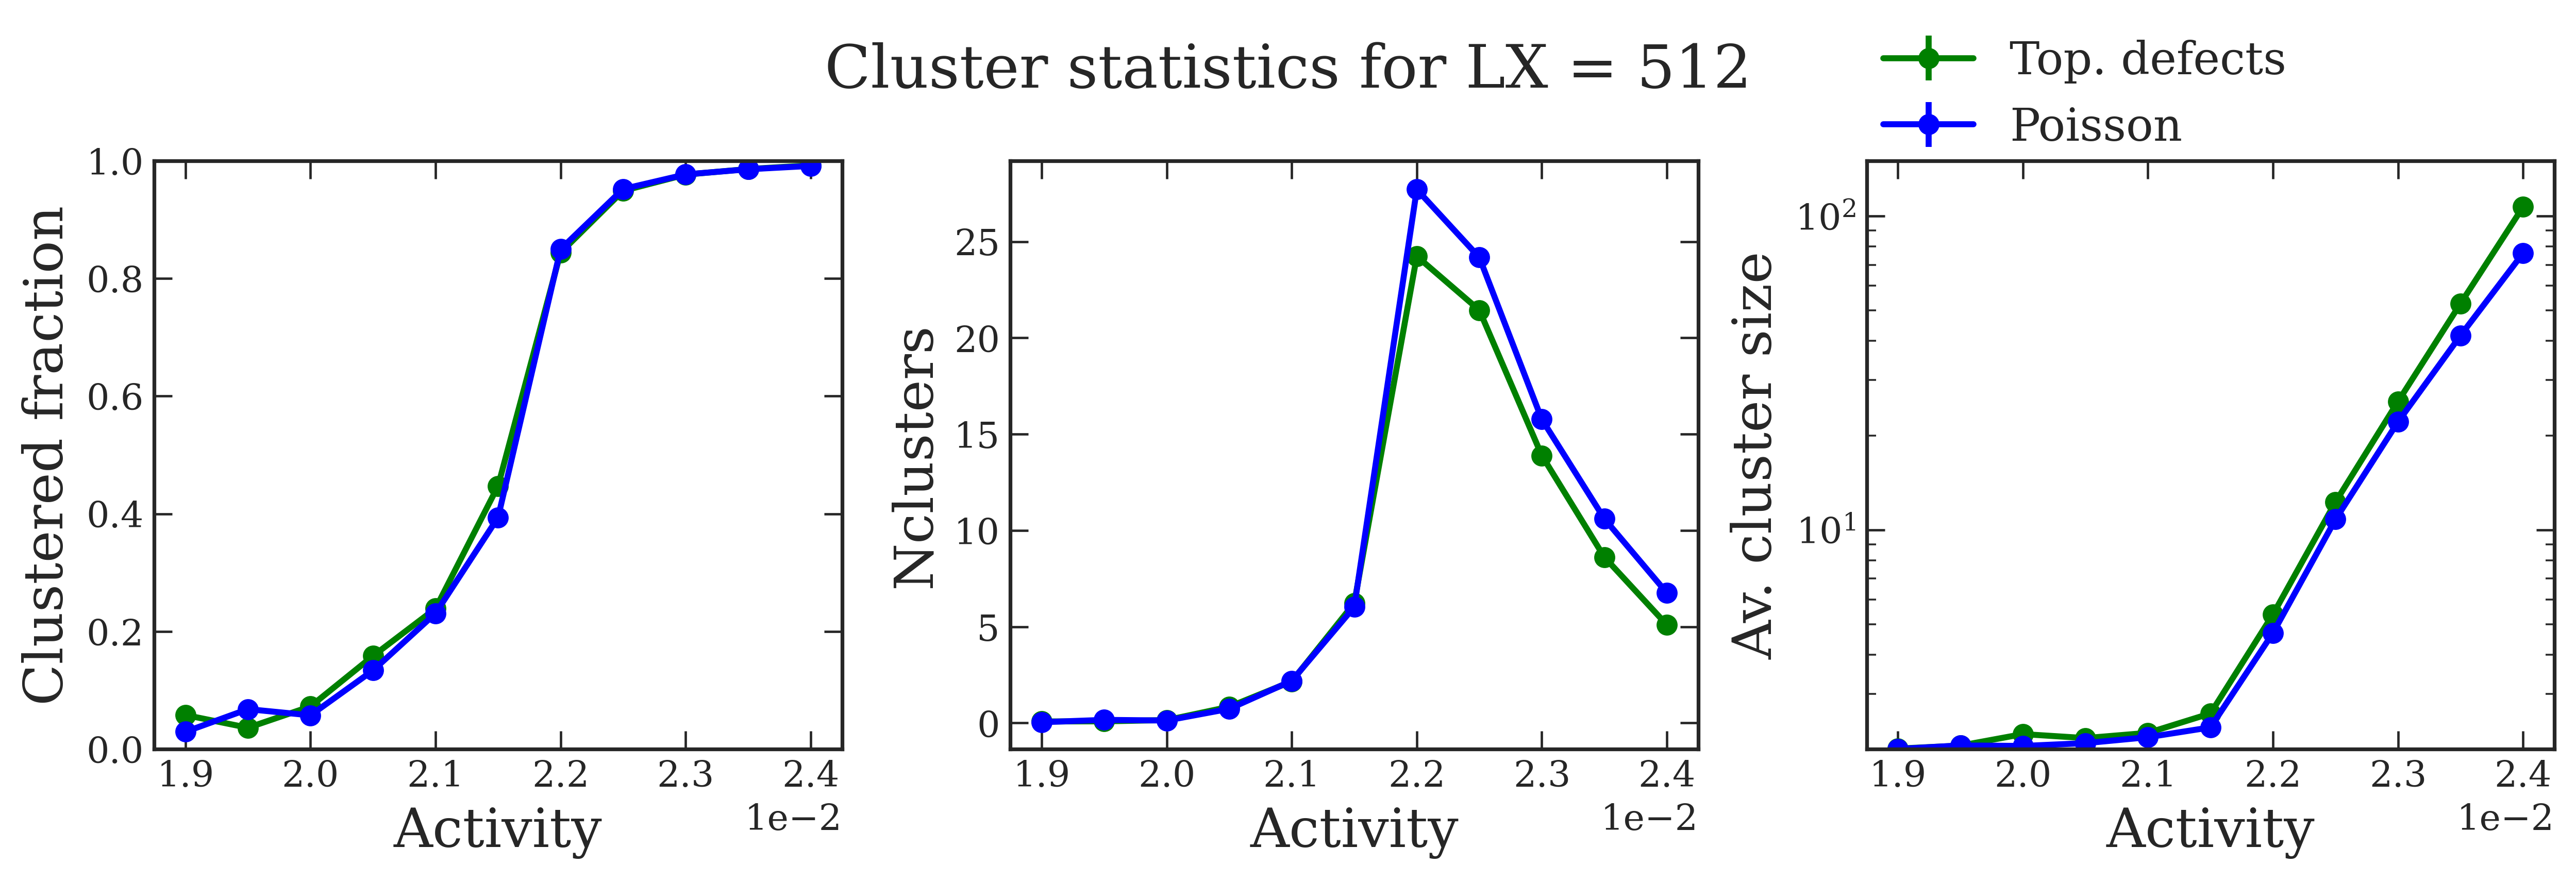

In [237]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4)) 
Y = [cl_mean[1,:] / cl_mean[0, :], cl_mean[2,:], cl_mean[3,:]]
dY = [cl_std[1,:] / cl_mean[0, :], cl_std[2,:], cl_std[3,:]]

Y_uni = [cl_mean_uni[1,:] / cl_mean_uni[0, :], cl_mean_uni[2,:], cl_mean_uni[3,:]]
dY_uni = [cl_std_uni[1,:] / cl_mean_uni[0, :], cl_std_uni[2,:], cl_std_uni[3,:]]

for i in range(3):
    if i == 0:
        ax[i].set_ylim(0, 1)    
        kwargs_dict = dict(label = 'Top. defects')
        kwargs_dict_uni = dict(label = 'Poisson')
    else:
        kwargs_dict = dict()
        kwargs_dict_uni = dict()
    ax[i].errorbar(act_list, Y[i], yerr=dY[i], fmt='-o', color = 'green', **kwargs_dict)
    ax[i].errorbar(act_list, Y_uni[i], yerr=dY_uni[i], fmt='-o', color = 'blue', **kwargs_dict_uni)
    ax[i].set_xlabel(f'Activity')
    ax[i].set_ylabel(['Clustered fraction','Nclusters', 'Av. cluster size'][i])
    #ax[i].legend()
ax[-1].set_ylim(2, 150)  
#ax[0].set_ylim(0.01,1.1)
#ax[0].set_yscale('log')
ax[-1].set_yscale('log')   
fig.suptitle(f'Cluster statistics for LX = 512');
fig.legend(loc = 'upper right', bbox_to_anchor=(0.9, 1.03))

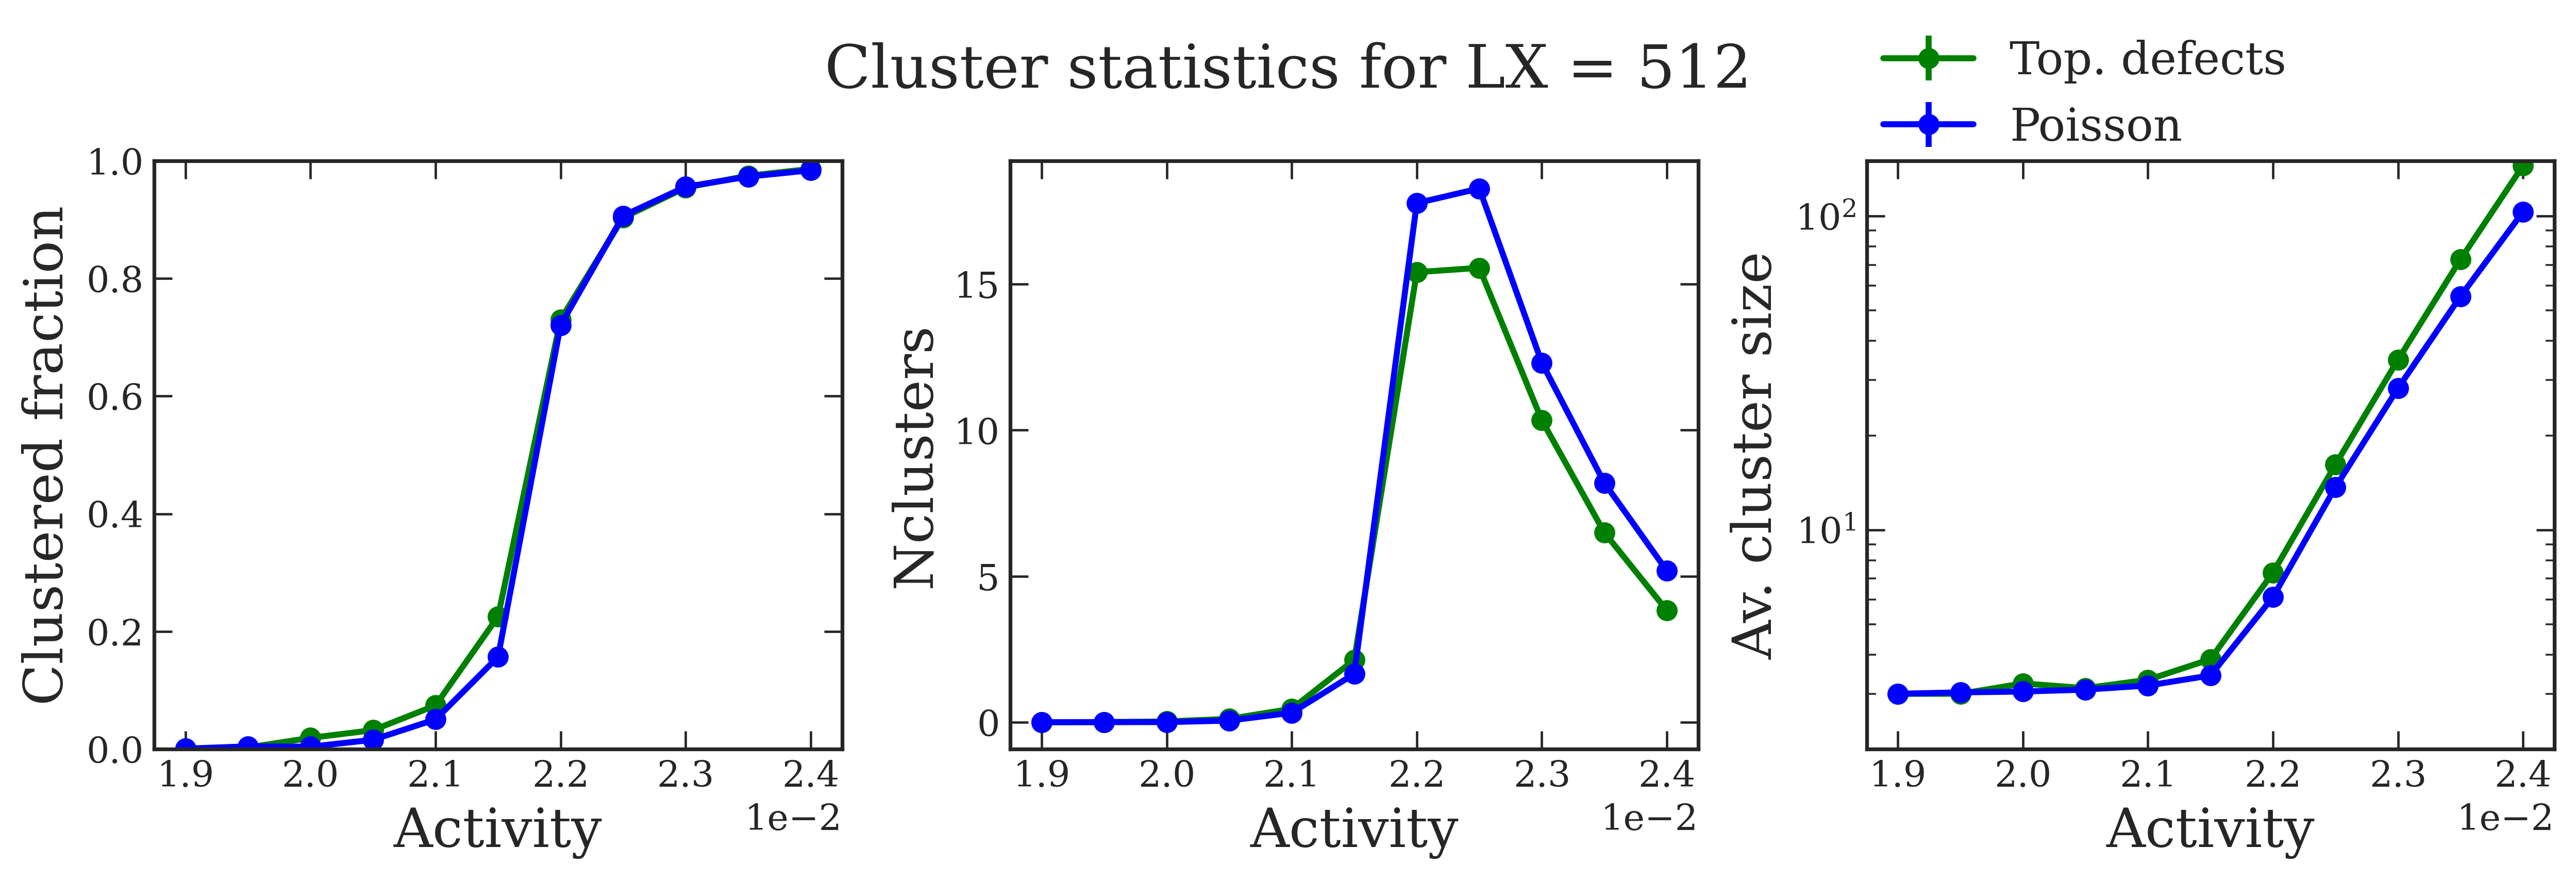

In [219]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4)) 
Y = [cl_mean[1,:] / cl_mean[0, :], cl_mean[2,:], cl_mean[3,:]]
dY = [cl_std[1,:] / cl_mean[0, :], cl_std[2,:], cl_std[3,:]]

Y_uni = [cl_mean_uni[1,:] / cl_mean_uni[0, :], cl_mean_uni[2,:], cl_mean_uni[3,:]]
dY_uni = [cl_std_uni[1,:] / cl_mean_uni[0, :], cl_std_uni[2,:], cl_std_uni[3,:]]

for i in range(3):
    if i == 0:
        ax[i].set_ylim(0, 1)    
        kwargs_dict = dict(label = 'Top. defects')
        kwargs_dict_uni = dict(label = 'Poisson')
    else:
        kwargs_dict = dict()
        kwargs_dict_uni = dict()
    ax[i].errorbar(act_list, Y[i], yerr=dY[i], fmt='-o', color = 'green', **kwargs_dict)
    ax[i].errorbar(act_list, Y_uni[i], yerr=dY_uni[i], fmt='-o', color = 'blue', **kwargs_dict_uni)
    ax[i].set_xlabel(f'Activity')
    ax[i].set_ylabel(['Clustered fraction','Nclusters', 'Av. cluster size'][i])
    #ax[i].legend()
ax[-1].set_ylim(2, 150)  
#ax[0].set_ylim(0.01,1.1)
#ax[0].set_yscale('log')
ax[-1].set_yscale('log')   
fig.suptitle(f'Cluster statistics for LX = 512');
fig.legend(loc = 'upper right', bbox_to_anchor=(0.9, 1.03))

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13540\1473006197.py:69: RuntimeWarning: invalid value encountered in divide
  res_norm = Ydif / Ydif_err
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13540\1473006197.py:42: RuntimeWarning: invalid value encountered in divide
  res_norm = Ydif / Ydif_err


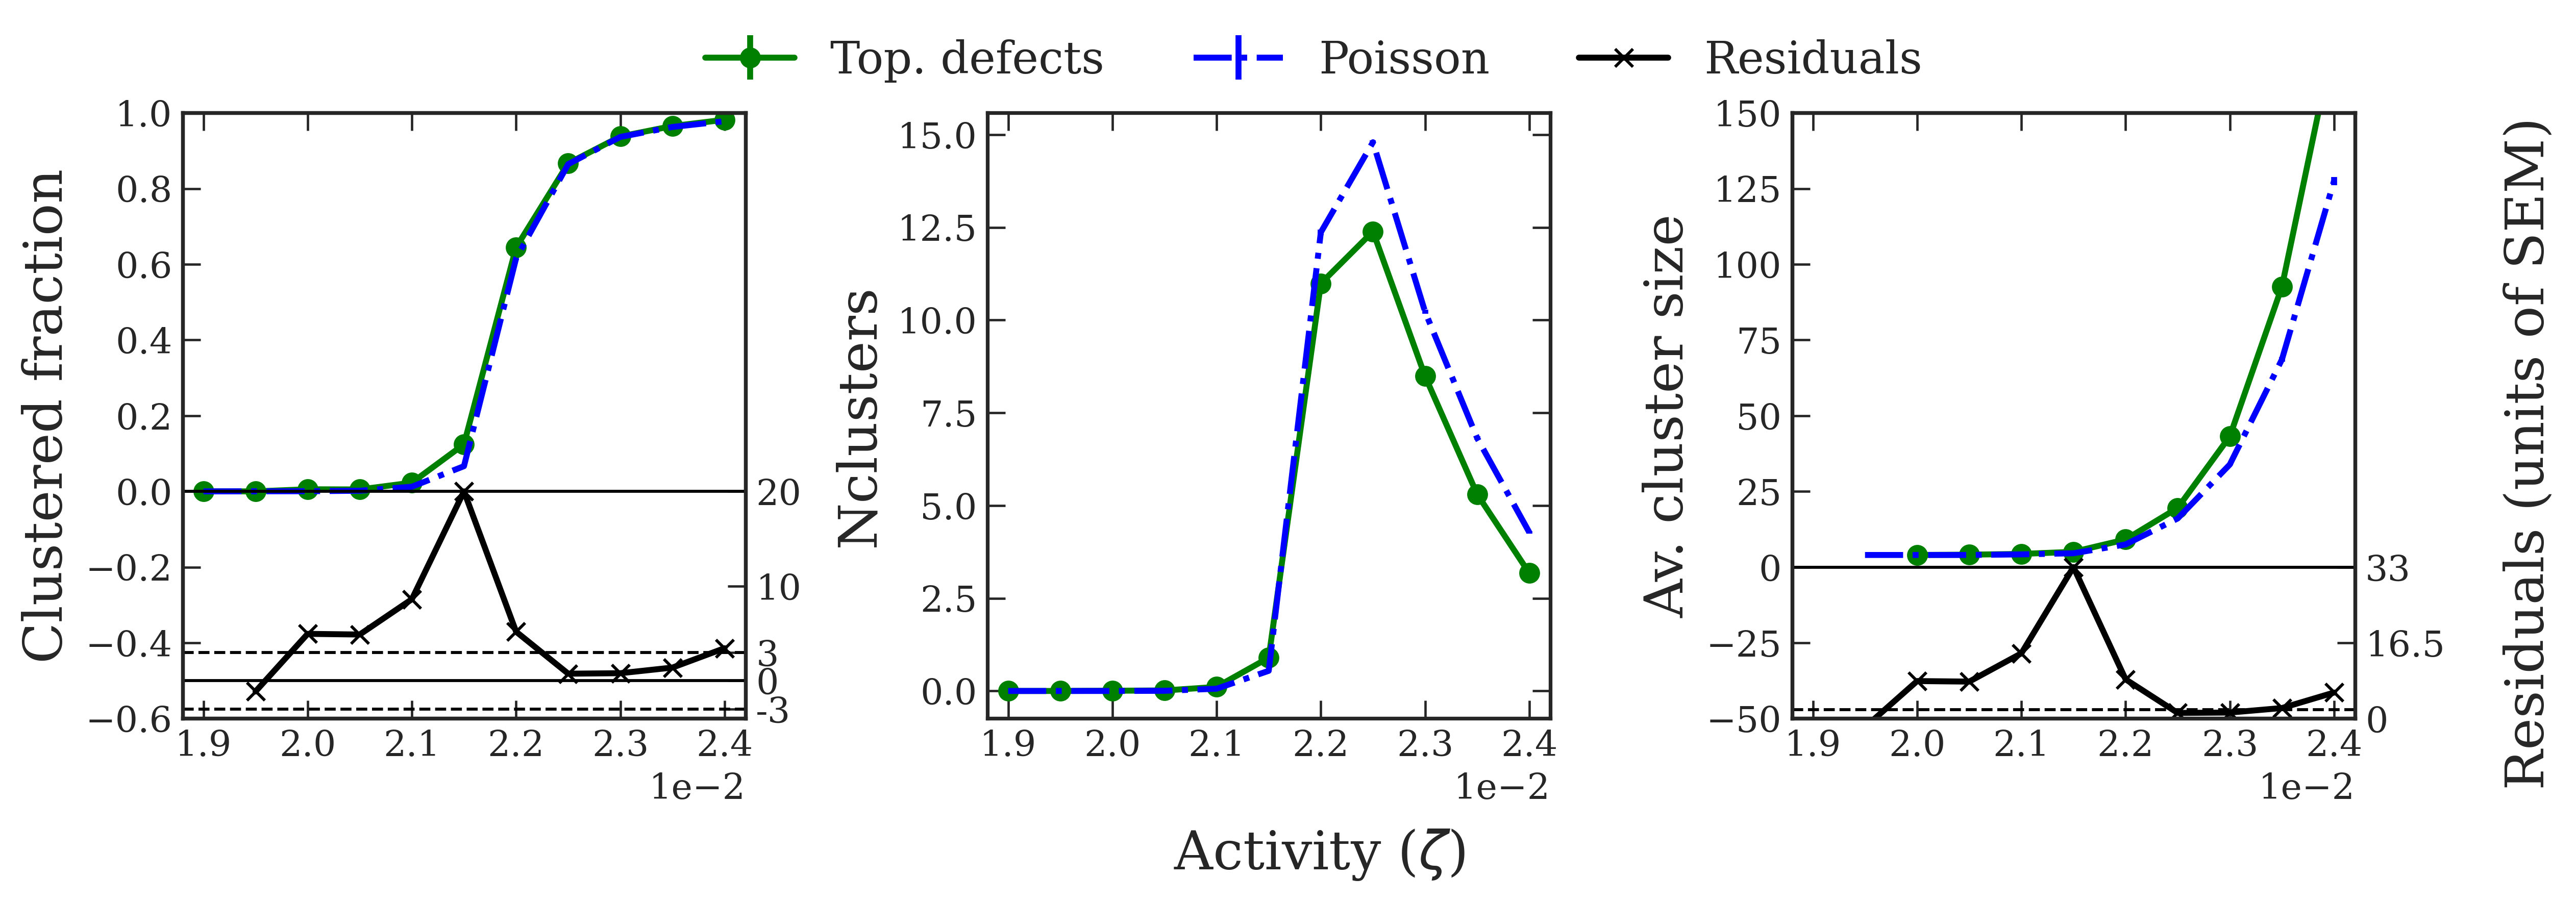

In [423]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4)) 
Y = [cl_mean[1,:] / cl_mean[0, :], cl_mean[2,:], cl_mean[3,:]]
dY = [cl_std[1,:] / cl_mean[0, :], cl_std[2,:], cl_std[3,:]]

Y_uni = [cl_mean_uni[1,:] / cl_mean_uni[0, :], cl_mean_uni[2,:], cl_mean_uni[3,:]]
dY_uni = [cl_std_uni[1,:] / cl_mean_uni[0, :], cl_std_uni[2,:], cl_std_uni[3,:]]

for i in range(3):
    if i == 0:
        ax[i].set_ylim(0, 1)    
        kwargs_dict = dict(label = 'Top. defects')
        kwargs_dict_uni = dict(label = 'Poisson')
    else:
        kwargs_dict = dict()
        kwargs_dict_uni = dict()
    ax[i].errorbar(act_list, Y[i], yerr=dY[i], fmt='-o', color = 'green', **kwargs_dict)
    ax[i].errorbar(act_list, Y_uni[i], yerr=dY_uni[i], fmt='-.', color = 'blue', **kwargs_dict_uni)
 #   ax[i].set_xlabel(f'Activity')
    ax[i].set_ylabel(['Clustered fraction','Nclusters', 'Av. cluster size'][i])
    #ax[i].legend()
  #  ax[i].set_xticks(np.arange(0.019,0.024,0.001), np.arange(0.019,0.024,0.001))
  #  ax[i].set_xlim(1.89e-2,2.41e-2)
    axinn_xlims = [1.88e-2, 2.42e-2]
    axinn_xticks = np.linspace(axinn_xlims[0]+2e-4, axinn_xlims[1] - 2e-4,6)
    

    ax[i].set(xticks=axinn_xticks, xlim=axinn_xlims)
    #ax[i].ticklabel_format(style='sci',scilimits=(-1,1),axis='x')

    if i == 2:
        bottom = -50
        res_zero = bottom
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + res_zero) 
        show_std_lines_for = 3

        ax[i].set_ylim(bottom, - 3*bottom)
        axx0 = ax[i].twinx()
        Ydif = Y[0] -  Y_uni[0]
        Ydif_err = np.sqrt(dY[0]**2 + dY_uni[0]**2)
        res_norm = Ydif / Ydif_err

        # normalize res_norm by biggest value
        res_norm_unit = shift * res_norm / np.nanmax(np.abs(res_norm)) + res_zero

       # axx0.set(ylabel = 'Residuals (units of SEM)')
        axx0.set_yticks([res_zero, res_zero + shift/2, top],\
                         [0, 33/2,33,])
        axx0.set_ylim((bottom, -3*bottom))
        axx0.axhline(y=0, color='black', linewidth=1)
        axx0.axhline(y=res_zero, color='black', linewidth=1)
        axx0.axhline(y=res_zero + shift * show_std_lines_for/shift, color='k', lw=1, linestyle='--')

        axx0.plot(act_list, res_norm_unit, 'kx-',) #label='Residuals')

    if i == 0:
        bottom = -.6
        res_zero = -.5
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + res_zero)
        show_std_lines_for = 3

        ax[i].set_ylim(bottom, 1)
        axx0 = ax[i].twinx()
        Ydif = Y[0] -  Y_uni[0]
        Ydif_err = np.sqrt(dY[0]**2 + dY_uni[0]**2)
        res_norm = Ydif / Ydif_err

        # normalize res_norm by biggest value
        res_norm_unit = shift * res_norm / np.nanmax(np.abs(res_norm)) + res_zero

       # axx0.set(ylabel = 'Residuals (units of SEM)')
        axx0.set_yticks([res_zero - shift * show_std_lines_for/20, res_zero, res_zero + shift * show_std_lines_for/20, res_zero + shift/2, top],\
                         [-show_std_lines_for, 0,show_std_lines_for, 10,20,])
        axx0.set_ylim((bottom, 1))
        axx0.axhline(y=0, color='black', linewidth=1)
        axx0.axhline(y=res_zero, color='black', linewidth=1)
        axx0.axhline(y=res_zero - shift * show_std_lines_for/20, color='k', lw=1, linestyle='--')
        axx0.axhline(y=res_zero + shift * show_std_lines_for/20, color='k', lw=1, linestyle='--')

        axx0.plot(act_list, res_norm_unit, 'kx-', label='Residuals')
       # axx0.legend()

ax[-1].set_ylim(-50, 150)  
#ax[0].set_ylim(-0.05,1.05)
#ax[0].set_yscale('log')
#ax[-1].set_yscale('log')   
#fig.suptitle(f'Cluster statistics for LX = 512');
fig.legend(loc = 'upper right', ncol=3, bbox_to_anchor=(0.8, 1.08))
fig.supylabel(t='Residuals (units of SEM)', x=1.01, y=0.55)
fig.supxlabel(t = f'Activity ($\zeta$)', y=0.05, x=0.55)
fig.tight_layout()

In [401]:
np.arange(0.019,0.025,0.001)

array([0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025])

In [393]:
res_norm_unit

array([         nan, -50.00114384, -49.99505529, -49.99512538,
       -49.99139286, -49.98      , -49.99482446, -49.99926424,
       -49.99921355, -49.9986175 , -49.99657192])

In [285]:
Ydif = Y[0] -  Y_uni[0]
Ydif_err = np.sqrt(dY[0]**2 + dY_uni[0]**2)
Ydif / Ydif_err

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13540\640523184.py:3: RuntimeWarning: invalid value encountered in divide
  Ydif / Ydif_err


array([        nan, -1.0527774 ,  4.55106099,  4.48655692,  7.92192531,
       18.40780464,  4.7635164 ,  0.67718377,  0.72384541,  1.2724359 ,
        3.15516709])

In [424]:
zstat[-2,:]

array([         nan,  -1.0527774 ,   4.55011328,   4.38501271,
         7.47650053,  15.64316163, -14.30267109, -34.45952054,
       -24.88476844, -23.98064125, -26.73707785])

In [278]:
zstat[1,:]/zstat[0,:]

array([         nan,  12.1707916 , -42.60192216,  -3.27755232,
        -6.15967627,  -8.75410384,  29.79032751,   2.82006313,
         7.39435243,  -0.78632982,  -1.29135543])

In [273]:
zstat[-1,:]

array([        nan,         nan,         nan, 21.69304578, 11.58916781,
       20.34185039, 32.81169601, 23.36638881, 17.87784732, 17.989907  ,
       21.35139075])


p-value that data is shifted towards high values:  1.1279545992012228e-06
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) -1.9456770599215067 0.9741357354115303

p-value that data is shifted towards high values:  3.759439431216203e-170
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) -27.506588039268596 1.0

p-value that data is shifted towards high values:  1.0
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) 22.63897677824371 2.4333473322284352e-110


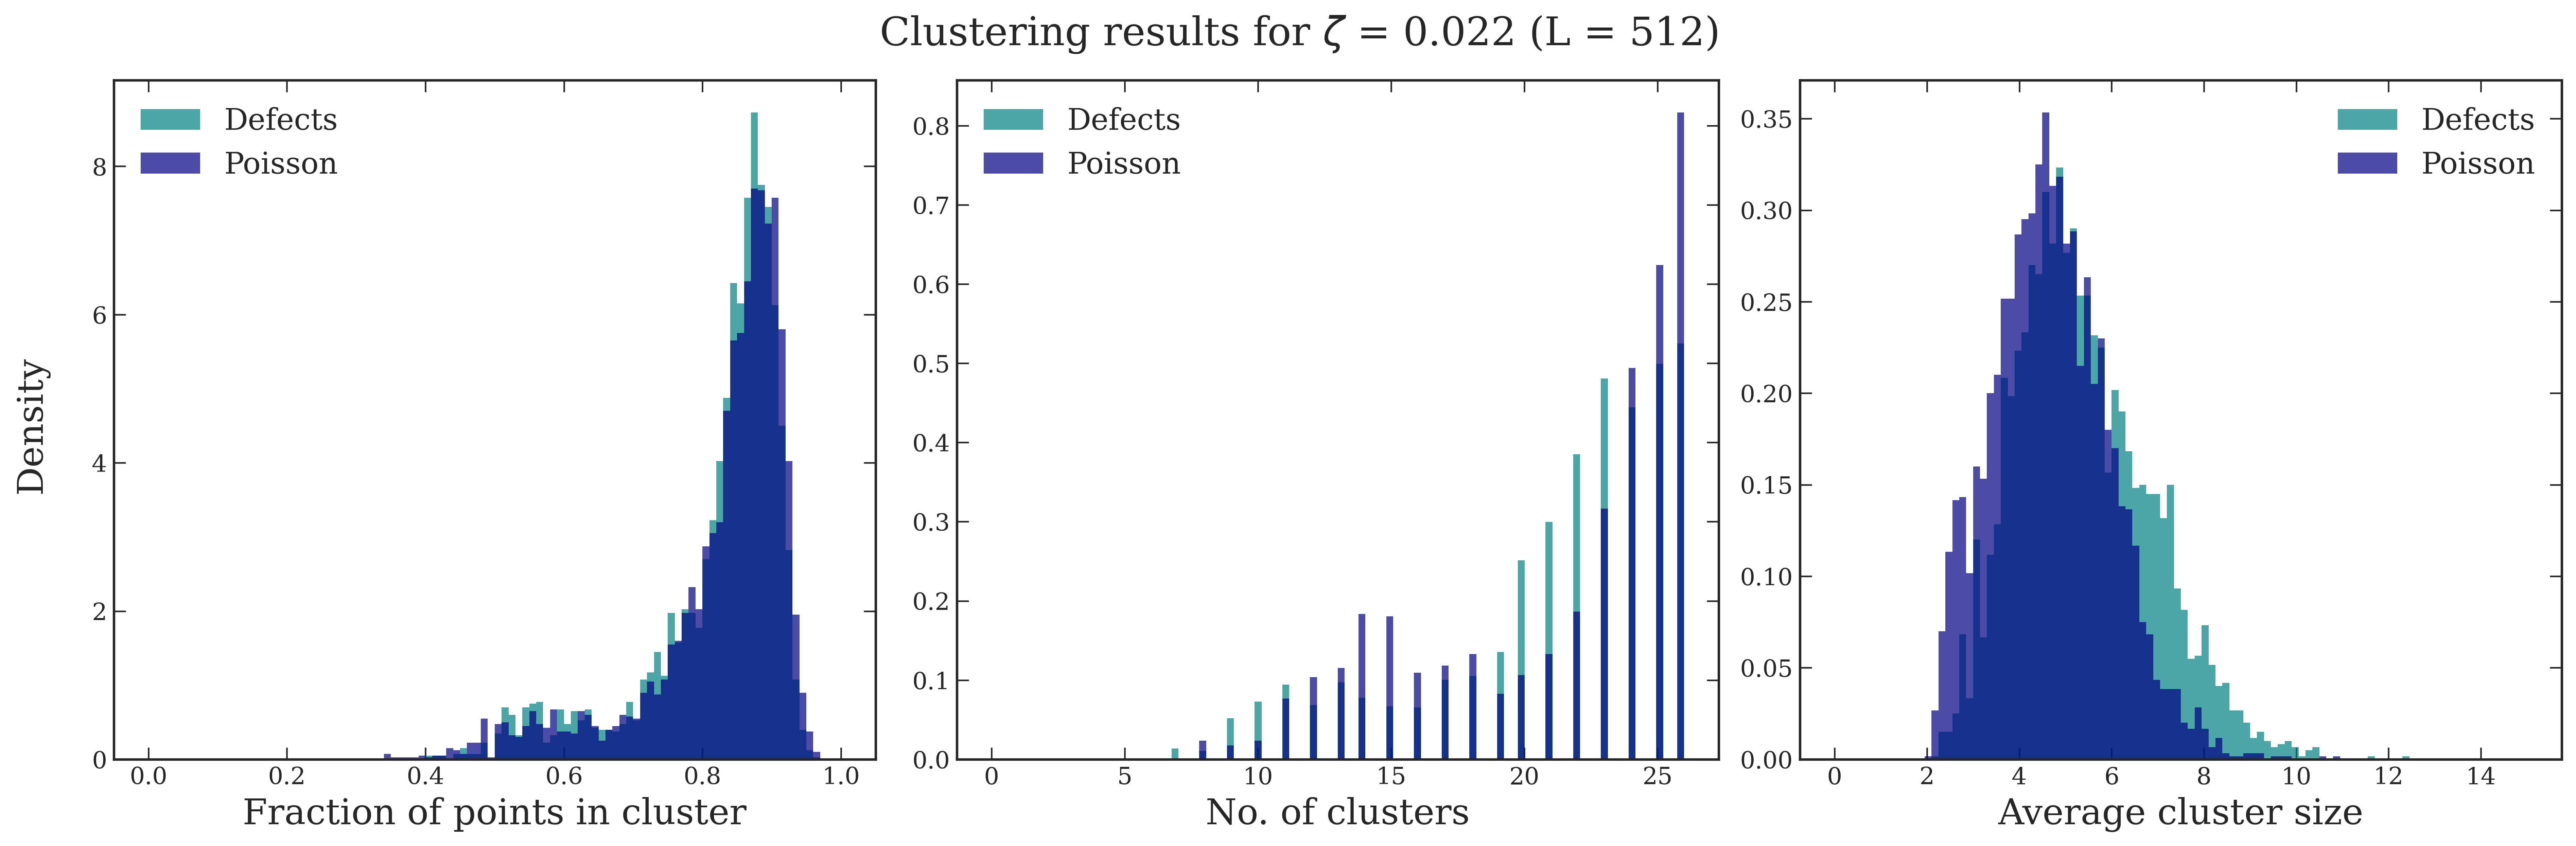

In [251]:
cl_frac = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
cl_frac_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]

act = 0.022
act_idx = act_vl.index(act)
act_idx_uni = list(act_list).index(act)

fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = ax.flatten()
title_list = ['Fraction of points in cluster', 'No. of clusters', 'Average cluster size']
range_list = [(0, 1), (0, 26), (0, 15)]
nbins_list = [100, 100, 100]
nbins = 100
for i, axx in enumerate(ax):
    if i == 0:
        data = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
        data_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]
    else:
        data = cl_arr_vl[:, i + 1, :, :]
        data_uni = cl_arr_uni[i + 1, :, :]

    ## Examine combatibility with Kolmogrov test under the null hypothesis that the cumulative distribution of data if shifted
    # towards larger values than data_uni (so that F_drug(x) <= F_control(x))
    _, p_val = stats.ks_2samp(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), alternative = 'greater')

    print('\np-value that data is shifted towards high values: ', p_val)

    # Use t-test to calculate p_value under the null hypothesis that the 2 means are equal, letting the alternative hypothesis be that the mean of the drug group
    # is greater than that of the control group
    t_val, p_val = stats.ttest_ind(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), equal_var = True, alternative = 'greater')

    print("t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test)", t_val, p_val)

    density = True if i < 3 else False
    axx.hist(data[:, act_idx, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], histtype='stepfilled', alpha=.7, label = 'Defects', density=density)
    axx.hist(data_uni[act_idx_uni, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], histtype='stepfilled', alpha=.7, label = 'Poisson', density=density)
    axx.set_xlabel(xlabel = title_list[i])
    axx.legend()
fig.supylabel(t = 'Density', x=0.0);
fig.suptitle(t = rf'Clustering results for $\zeta$ = {act} (L = {L})');

Text(0.5, 0.98, 'Clustering results for $\\zeta$ = 0.022 (L = 512)')

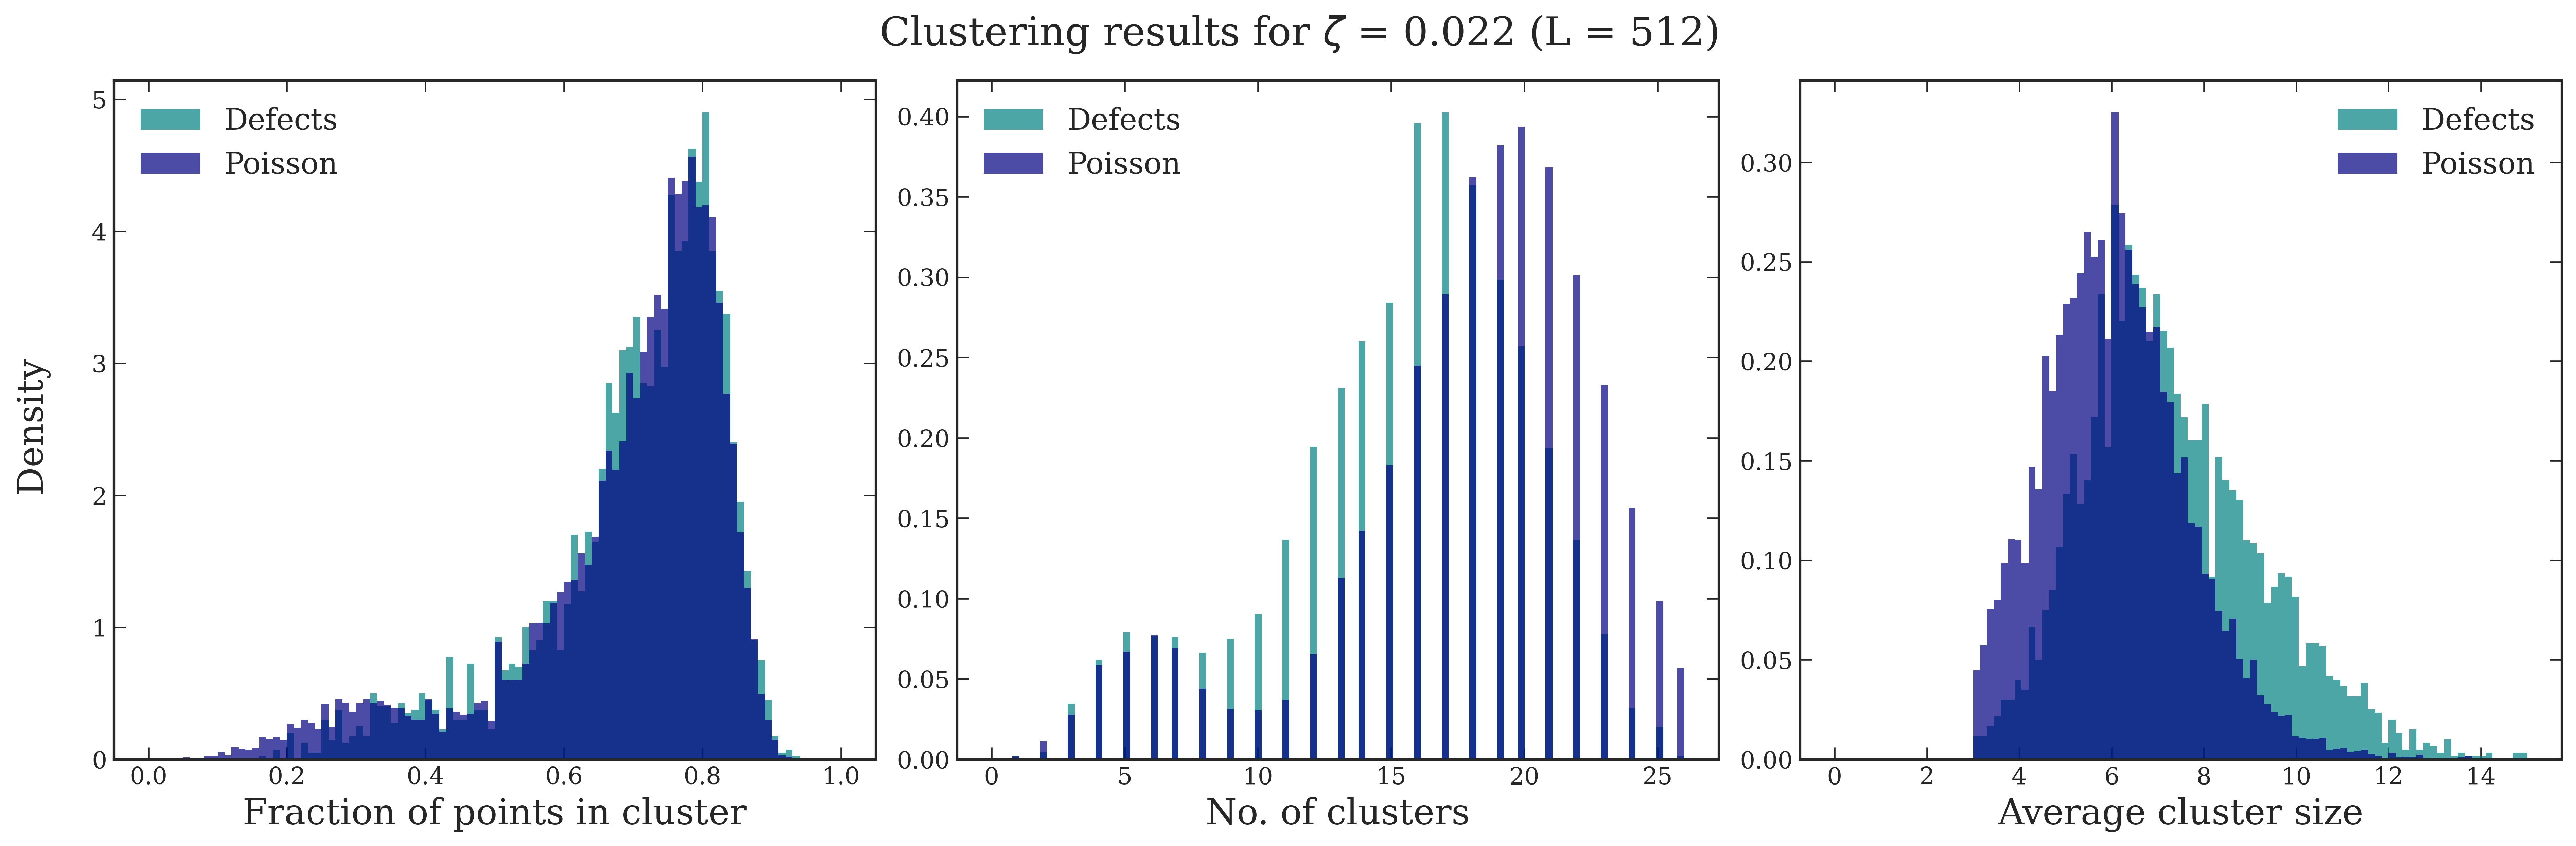

In [229]:
cl_frac = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
cl_frac_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]

act = 0.022
act_idx = act_vl.index(act)
act_idx_uni = list(act_list).index(act)

fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = ax.flatten()
title_list = ['Fraction of points in a cluster', 'No. of clusters', 'Average cluster size']
range_list = [(0, 1), (0, 26), (0, 15)]
nbins_list = [100, 100, 100]
nbins = 100
for i, axx in enumerate(ax):
    if i == 0:
        data = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
        data_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]
    else:
        data = cl_arr_vl[:, i + 1, :, :]
        data_uni = cl_arr_uni[i + 1, :, :]

    density = True if i < 3 else False
    axx.hist(data[:, act_idx, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], histtype='stepfilled', alpha=.7, label = 'Defects', density=density)
    axx.hist(data_uni[act_idx_uni, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], histtype='stepfilled', alpha=.7, label = 'Poisson', density=density)
    axx.set_xlabel(xlabel = title_list[i])
    axx.legend()
fig.supylabel(t = 'Density', x=0.0);
fig.suptitle(t = rf'Clustering results for $\zeta$ = {act} (L = {L})')


p-value that cum_dist of data_uni is shifted towards higher values than data:  1.1228739800664826e-09
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) 8.789590533156298 9.102530192592907e-19

p-value that cum_dist of data_uni is shifted towards higher values than data:  0.7101975549229821
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) -14.30088314447385 1.0

p-value that cum_dist of data_uni is shifted towards higher values than data:  8.334768608134448e-145
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) nan nan


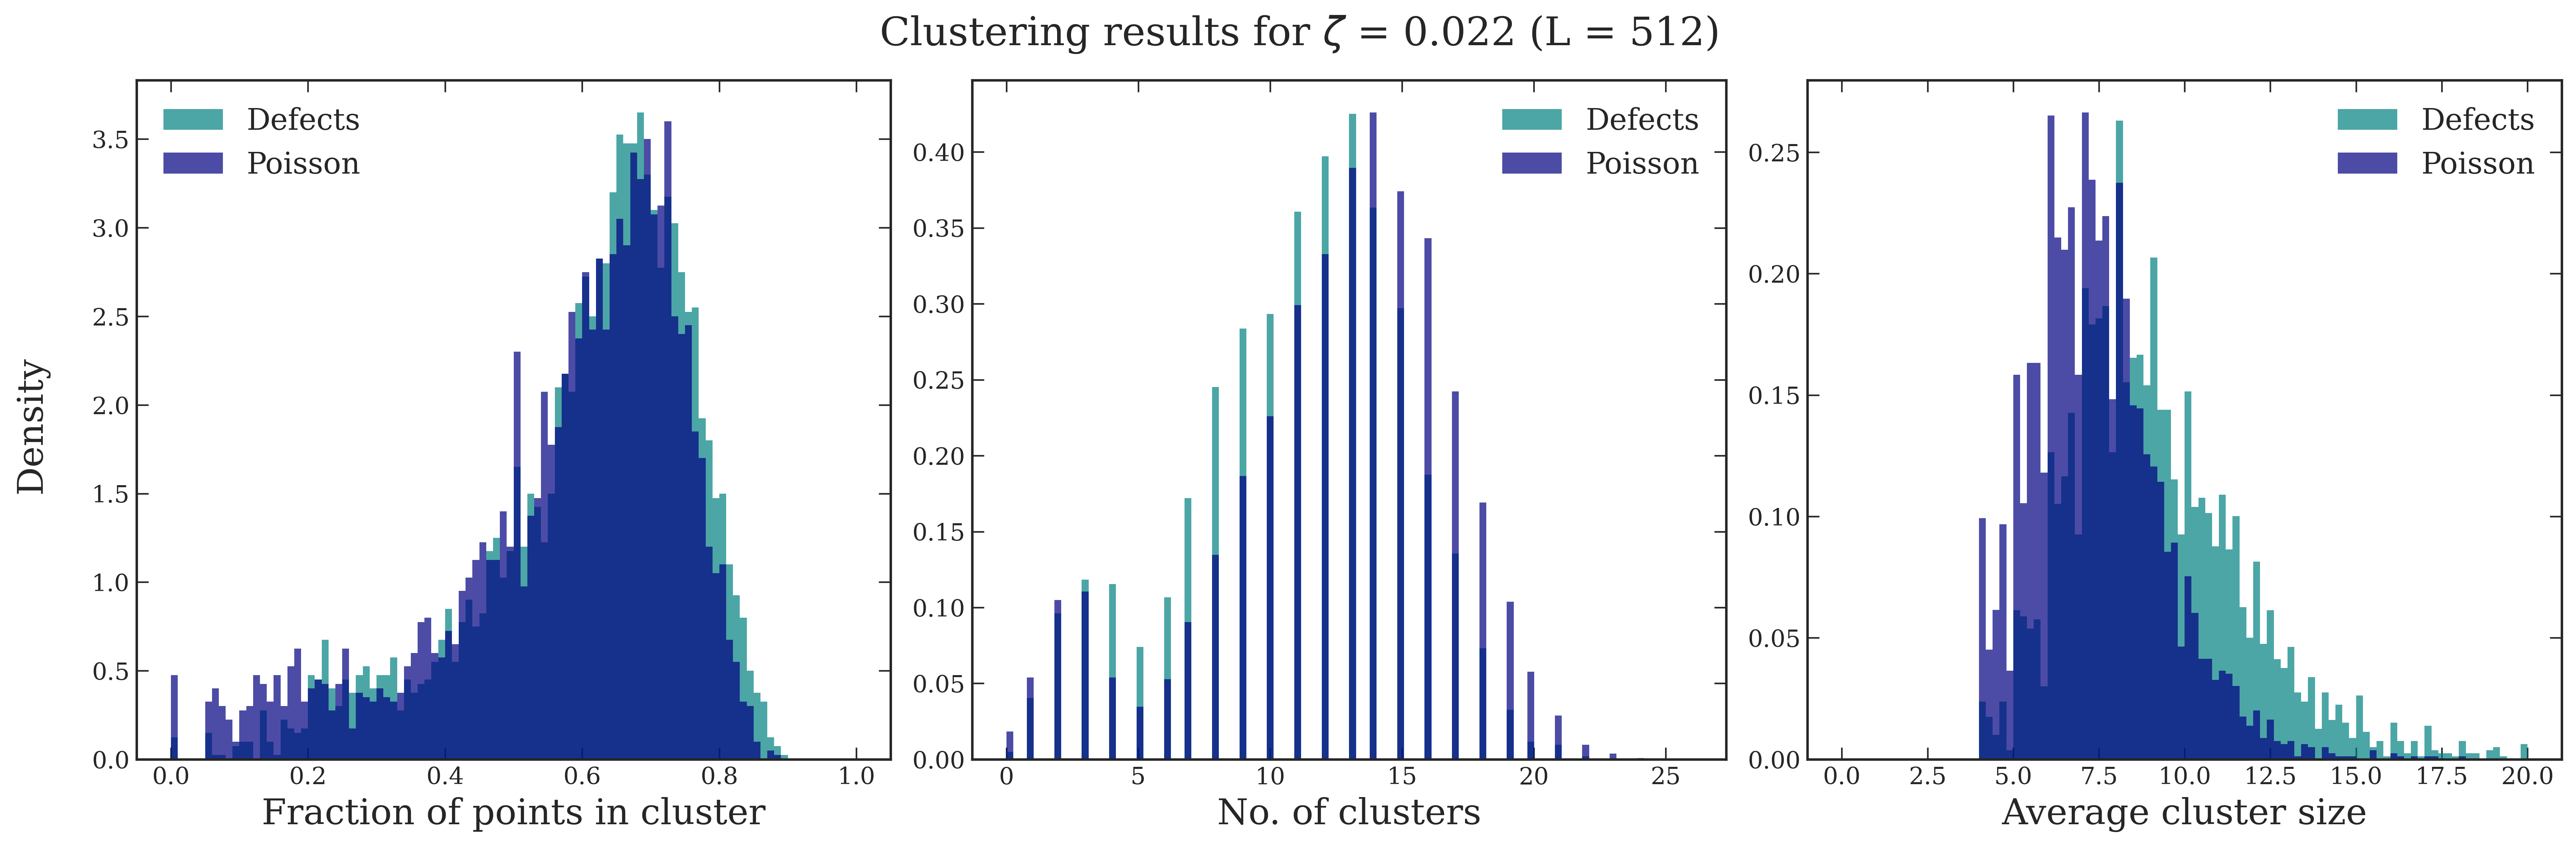

In [267]:
cl_frac = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
cl_frac_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]

act = 0.022
act_idx = act_vl.index(act)
act_idx_uni = list(act_list).index(act)

fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = ax.flatten()
title_list = ['Fraction of points in cluster', 'No. of clusters', 'Average cluster size']
range_list = [(0, 1), (0, 26), (0, 20)]
nbins_list = [100, 100, 100]
nbins = 100
for i, axx in enumerate(ax):
    if i == 0:
        data = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
        data_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]
    else:
        data = cl_arr_vl[:, i + 1, :, :]
        data_uni = cl_arr_uni[i + 1, :, :]

    ## Examine combatibility with Kolmogrov test under the null hypothesis that the cumulative distribution of data_uni if shifted
    # towards larger values than data (so that Cum(data(x)) <= Cum(data_uni(x))). Alt. hypothesis: Cum(data(x)) > Cum(data_uni(x))
    _, p_val = stats.ks_2samp(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), alternative = 'less')

    print('\np-value that cum_dist of data_uni is shifted towards higher values than data: ', p_val)

    # Use t-test to calculate p_value under the null hypothesis that the 2 means are equal, letting the alternative hypothesis be that the mean of the drug group
    # is greater than that of the control group
    t_val, p_val = stats.ttest_ind(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), equal_var = False, alternative = 'greater')

    print("t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test)", t_val, p_val)

    density = True if i < 3 else False
    axx.hist(data[:, act_idx, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], histtype='stepfilled', alpha=.7, label = 'Defects', density=density)
    axx.hist(data_uni[act_idx_uni, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], histtype='stepfilled', alpha=.7, label = 'Poisson', density=density)
    axx.set_xlabel(xlabel = title_list[i])
    axx.legend()
fig.supylabel(t = 'Density', x=0.0);
fig.suptitle(t = rf'Clustering results for $\zeta$ = {act} (L = {L})');